<a href="https://colab.research.google.com/github/iliavk/rebalance-portfolio/blob/main/rebalance_simulation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Rebalancing Strategies: A Comparative Study

This project explores different portfolio rebalancing strategies for a simple two-asset portfolio composed of:
- **70% SPY** — an ETF tracking the S&P 500 index
- **30% BIL** — an ETF tracking short-term U.S. Treasury Bills (1–3 months)

We simulate and compare four approaches:
- **Daily rebalancing**
- **Monthly rebalancing**
- **Buy & hold**
- **Threshold-based rebalancing** (only rebalance when the stock weight drifts outside a specified tolerance)

We evaluate each strategy on:
- Compound Annual Growth Rate (CAGR)
- Volatility
- Sharpe Ratio
- Maximum Drawdown
- Number of rebalancing events (for threshold strategy)

All simulations use SPY daily data from **2010 to 2025** and assume a constant 5% annual return on T-Bills.

The goal is to understand how rebalancing frequency affects portfolio performance, trading cost, and risk-adjusted return.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look better
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Data Loading

We use historical daily prices for the following ETFs:

- **SPY** — tracks the S&P 500 index
- **BIL** — tracks short-term U.S. Treasury bills (1–3 month maturity)

Prices are downloaded using the `yfinance` library, and adjusted for dividends and splits.

The simulation period is **January 2010 to July 2025**.

In [ ]:
# Download
spy = yf.download("SPY", start="2010-01-01", auto_adjust=True)
bil = yf.download("BIL", start="2010-01-01", auto_adjust=True)

stock_data = spy["Close"].dropna()
tbill_data = bil["Close"].dropna()

common_dates = stock_data.index.intersection(tbill_data.index)

stock_data = stock_data.loc[common_dates]
tbill_data = tbill_data.loc[common_dates]

# Combine into DataFrame
prices = pd.concat([stock_data, tbill_data], axis=1)
prices.columns = ["SPY", "BIL"]
prices.head()

## 2. Asset Behavior

Before simulating portfolio strategies, we visualize the price evolution of the two assets:

- **SPY** (an ETF tracking the S&P 500) represents the equity portion of the portfolio.
- **BIL** (an ETF tracking short-term U.S. Treasury bills) represents the risk-free or low-risk component.

Both price series are normalized to start at 1.0 in 2010 to allow for direct visual comparison of their growth paths.

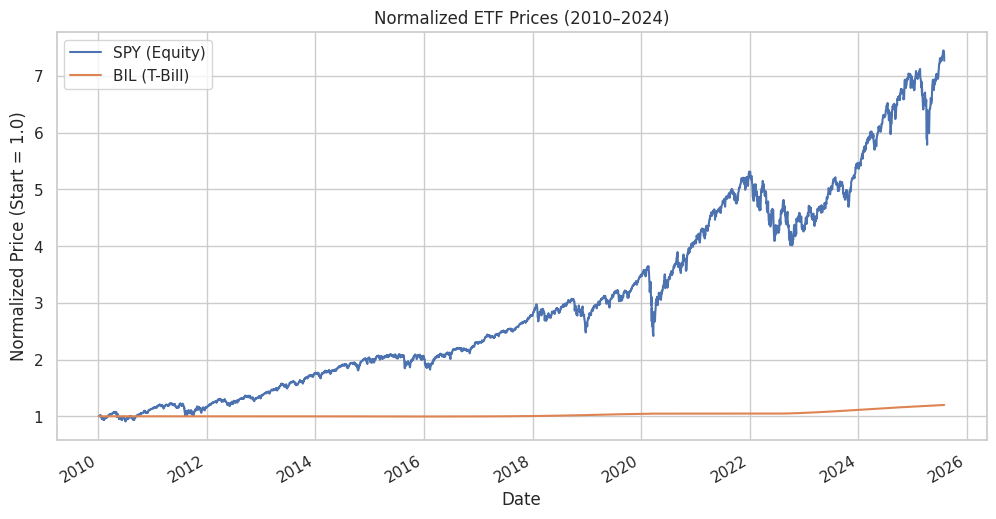

In [ ]:
# Normalize both series to start at 1.0
spy_norm = prices["SPY"] / prices["SPY"].iloc[0]
bil_norm = prices["BIL"] / prices["BIL"].iloc[0]

# Combine into a DataFrame for plotting
prices_norm = pd.DataFrame({
    'SPY (Equity)': spy_norm,
    'BIL (T-Bill)': bil_norm
})

# Plot the normalized prices
prices_norm.plot(figsize=(12, 6), title="Normalized ETF Prices (2010–2024)")
plt.ylabel("Normalized Price (Start = 1.0)")
plt.grid(True)
plt.show()

## 3. Portfolio Simulation

We simulate a two-asset portfolio composed of:

- **SPY** as the equity component.
- **BIL** as the risk-free component.

The simulation supports multiple rebalancing strategies:

- **Buy & Hold**: Allocate once and never rebalance.
- **Monthly**: Rebalance at the beginning of each month.
- **Daily**: Rebalance at every trading day.
- **Threshold-based**: Rebalance only when the portfolio drifts too far from target weights.

We simulate the portfolio value from 2010 to 2024 using different rebalancing rules, starting with an initial portfolio value of $1,000 and target weights of 30% in BIL and 70% in SPY. A small transaction cost of 0.05% is applied on rebalanced amounts to reflect realistic trading friction.

In [ ]:
def simulate_portfolio(prices,
                       rebalance_freq='daily',
                       initial_value=1000,
                       target_weights=(0.3, 0.7),
                       transaction_cost=0.0005,
                       threshold=0.0):
    """
    Simulate a two-asset portfolio using real ETF prices (SPY and BIL).

    Parameters:
    - prices: DataFrame with 'SPY' and 'BIL' columns (adjusted close)
    - rebalance_freq: 'daily', 'monthly', 'buy_and_hold', or 'threshold'
    - initial_value: starting portfolio value
    - target_weights: (tbill_weight, stock_weight)
    - transaction_cost: fraction charged on rebalanced volume
    - threshold: drift threshold (only used if rebalance_freq == 'threshold')
    """
    stock_prices = prices["SPY"]
    tbill_prices = prices["BIL"]
    dates = prices.index

    portfolio_value = []
    rebalance_count = 0

    # Initial allocation
    total = initial_value
    stock_value = target_weights[1] * total
    tbill_value = target_weights[0] * total
    last_rebalance = dates[0]

    for t in range(1, len(dates)):
        date = dates[t]
        prev = prices.iloc[t - 1]
        curr = prices.iloc[t]

        # Compute daily returns
        stock_return = curr["SPY"] / prev["SPY"] - 1
        tbill_return = curr["BIL"] / prev["BIL"] - 1

        # Update values
        stock_value *= (1 + stock_return)
        tbill_value *= (1 + tbill_return)

        # Check if rebalancing is needed
        do_rebalance = False

        if rebalance_freq == 'daily':
            do_rebalance = True
        elif rebalance_freq == 'monthly' and date.month != last_rebalance.month:
            do_rebalance = True
        elif rebalance_freq == 'buy_and_hold' and t == 1:
            do_rebalance = True
        elif rebalance_freq == 'threshold':
            total = stock_value + tbill_value
            current_weight = stock_value / total
            if abs(current_weight - target_weights[1]) > threshold:
                do_rebalance = True

        if do_rebalance:
            total = stock_value + tbill_value

            # Apply transaction cost (only on traded amount)
            desired_stock_value = target_weights[1] * total
            desired_tbill_value = target_weights[0] * total

            traded_stock = abs(desired_stock_value - stock_value)
            traded_tbill = abs(desired_tbill_value - tbill_value)
            cost = transaction_cost * (traded_stock + traded_tbill)

            total -= cost  # Deduct cost from portfolio
            stock_value = target_weights[1] * total
            tbill_value = target_weights[0] * total

            rebalance_count += 1
            last_rebalance = date

        portfolio_value.append(stock_value + tbill_value)

    return pd.Series(portfolio_value, index=dates[1:]), rebalance_count

In [ ]:
daily, count_d = simulate_portfolio(prices, 'daily', transaction_cost=0.0005)
monthly, count_m = simulate_portfolio(prices, 'monthly', transaction_cost=0.0005)
buy_hold, count_bh = simulate_portfolio(prices, 'buy_and_hold', transaction_cost=0.0005)
threshold1, count_t1 = simulate_portfolio(prices, rebalance_freq='threshold', threshold=0.03)
threshold2, count_t2 = simulate_portfolio(prices, rebalance_freq='threshold', threshold=0.05)
threshold3, count_t3 = simulate_portfolio(prices, rebalance_freq='threshold', threshold=0.1)

## 4. Strategy Comparison

Below we plot the evolution of portfolio value under all six rebalancing strategies.

This visual comparison highlights differences in growth trajectories, volatility, and timing of drawdowns. Note that some threshold strategies achieve similar performance with far fewer rebalances.

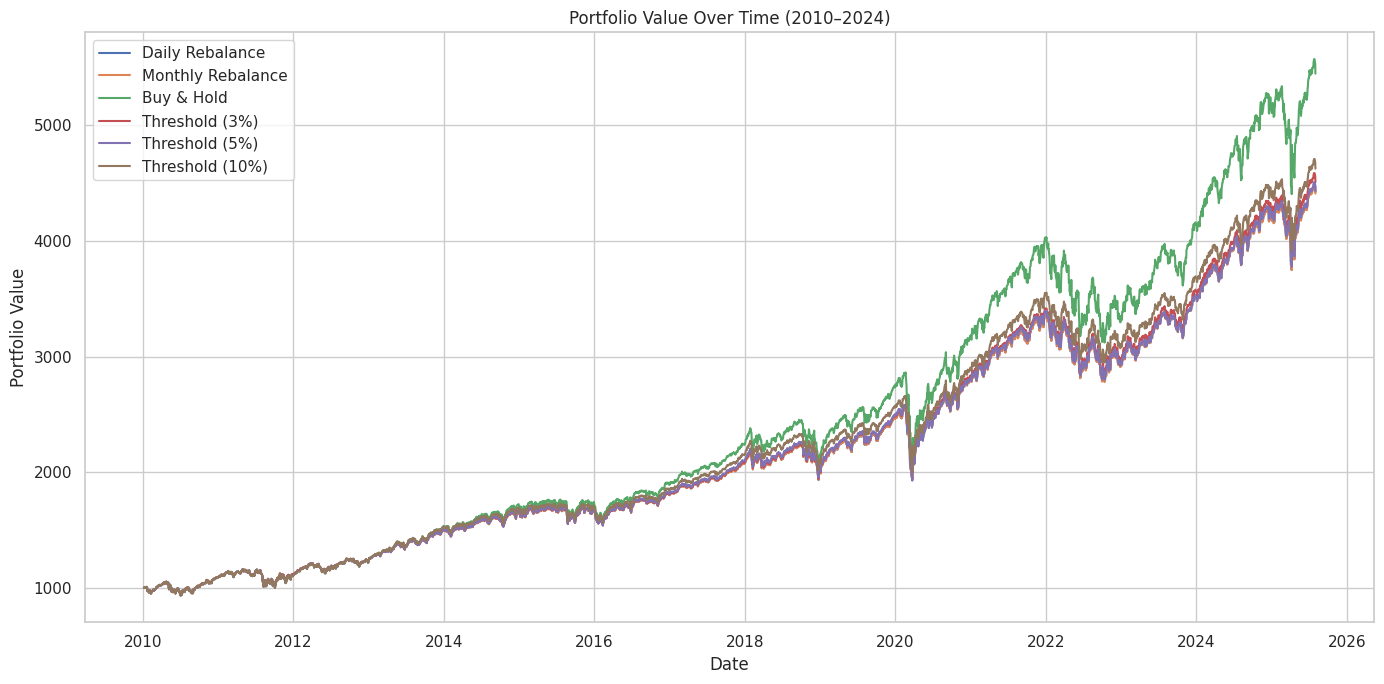

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(daily, label='Daily Rebalance')
plt.plot(monthly, label='Monthly Rebalance')
plt.plot(buy_hold, label='Buy & Hold')
plt.plot(threshold1, label='Threshold (3%)')
plt.plot(threshold2, label='Threshold (5%)')
plt.plot(threshold3, label='Threshold (10%)')

plt.title('Portfolio Value Over Time (2010–2024)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Performance Evaluation

We evaluate all six rebalancing strategies based on four key metrics:
- **CAGR (Compound Annual Growth Rate)**
- **Volatility**
- **Sharpe Ratio** (Assuming 5% risk-free rate)
- **Max Drawdown**

| Strategy           | CAGR   | Volatility | Sharpe Ratio | Max Drawdown |
|--------------------|--------|------------|---------------|---------------|
| Daily              | 10.01% | 12.14%     | 41.24%        | -24.49%       |
| Monthly            | 9.99%  | 12.01%     | 41.51%        | -24.09%       |
| Buy & Hold         | 11.49% | 14.66%     | 44.24%        | -29.99%       |
| Threshold (3%)     | 10.14% | 12.16%     | 42.28%        | -24.48%       |
| Threshold (5%)     | 10.02% | 12.24%     | 41.03%        | -25.09%       |
| Threshold (10%)    | 10.32% | 12.25%     | 43.47%        | -24.67%       |

**Interpretation:**
- **Buy & Hold** shows the highest CAGR, but also the highest drawdown and volatility.
- **Threshold (10%)** offers the best Sharpe ratio among the rebalancing strategies.
- **Monthly and Threshold (3%)** offer a good compromise between return and risk.
- **Daily rebalancing** does not offer significant benefit and could be inefficient with transaction costs.

⚠️ Note: These results assume a constant transaction cost of 0.05% per rebalance. No variations in cost were explored in this version.

In [ ]:
def compute_performance_metrics(portfolio_series, risk_free_rate=0.05):
    returns = portfolio_series.pct_change().dropna()
    total_days = (portfolio_series.index[-1] - portfolio_series.index[0]).days
    years = total_days / 365.25

    # CAGR
    final_value = portfolio_series.iloc[-1]
    initial_value = portfolio_series.iloc[0]
    cagr = (final_value / initial_value) ** (1 / years) - 1

    # Volatility
    vol = returns.std() * np.sqrt(252)

    # Sharpe (risk-free assumed constant)
    excess_return = cagr - risk_free_rate
    sharpe = excess_return / vol if vol != 0 else np.nan

    # Max drawdown
    running_max = portfolio_series.cummax()
    drawdown = portfolio_series / running_max - 1
    max_drawdown = drawdown.min()

    return {
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown
    }

# Collect all strategies
results = {
    "Daily": compute_performance_metrics(daily),
    "Monthly": compute_performance_metrics(monthly),
    "Buy & Hold": compute_performance_metrics(buy_hold),
    "Threshold (3%)": compute_performance_metrics(threshold1),
    "Threshold (5%)": compute_performance_metrics(threshold2),
    "Threshold (10%)": compute_performance_metrics(threshold3)
}

# Display as DataFrame
performance_df = pd.DataFrame(results).T

# Optional: format it nicely
performance_df = performance_df.applymap(lambda x: f"{x:.2%}" if isinstance(x, float) else x)
print(performance_df)

## 6. Rebalancing Frequency

Each strategy differs in how often it trades, which impacts transaction costs and operational complexity. Here are the total number of rebalancing events observed during the simulation period (2010–2024):

- **Daily**: 3918  
- **Monthly**: 187  
- **Buy & Hold**: 1  
- **Threshold (3%)**: 26  
- **Threshold (5%)**: 7  
- **Threshold (10%)**: 3  

This demonstrates the potential of threshold rebalancing: it can deliver returns similar to frequent strategies while dramatically reducing the number of rebalances — a desirable trait in real-world portfolio management.

In [ ]:
print("Daily rebalances:", count_d)
print("Monthly rebalances:", count_m)
print("Buy & Hold rebalances:", count_bh)
print("Threshold (3%) rebalances:", count_t1)
print("Threshold (5%) rebalances:", count_t2)
print("Threshold (10%) rebalances:", count_t3)

## 7. Conclusion

In this project, we compared six portfolio rebalancing strategies using real historical data from 2010 to 2024, focusing on a simple two-asset allocation between SPY (equity) and BIL (T-Bills).

Key takeaways:

- **Buy & Hold** delivered the highest absolute return but also had the highest volatility and deepest drawdown.
- **Daily and Monthly Rebalancing** helped control risk but offered no major performance edge after transaction costs.
- **Threshold Rebalancing** strategies struck a compelling balance — maintaining strong risk-adjusted returns with minimal trading activity.

This analysis suggests that simple threshold-based rules can offer **real-world efficiency** by preserving portfolio balance without overtrading — a valuable insight for both passive investors and systematic portfolio managers.